In [1]:
import pandas as pd
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift

Parameters

In [13]:
# Image File
image_file = 'sevens.jpg'

# Saturation cutoff to separate grays from colors
Sat_Cutoff = 0.2

# Value cutoffs for assiging black and white
Black_Cutoff = 0.1
White_Cutoff = 0.9

# Clustering area threshold
area_threshold = 0.85

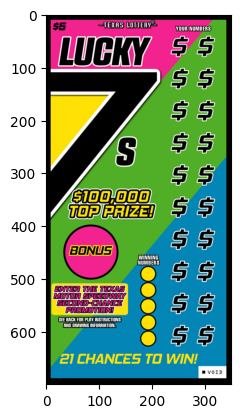

In [3]:
img = cv2.imread(image_file)

#Rearrange items for display because CV uses BGR and Matplotlib uses RGB
display(plt.imshow(img[:,:,::-1]))

In [4]:
# Convert 2-d 8-bit BGR image array to 1-d 8-bit HSV pixel array
HSV = (
    cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    .reshape(-1, 3)
)

# Convert numpy array of pixels into a pandas dataframe
Pixels = pd.DataFrame(HSV,columns=['H','S','V'])

# Separate color pixels from non-color pixels (Whites, Grays, Blacks)

# Handle Desaturated Pixels
mask = Pixels.iloc[:, 1] <= (Sat_Cutoff * 255)
GrayPixels = Pixels[mask]
ColorPixels = Pixels[~mask]

# Handle Black Pixels
mask = ColorPixels.iloc[:, 2] <= (Black_Cutoff * 255)
GrayPixels = pd.concat([GrayPixels,ColorPixels[mask]])
ColorPixels = ColorPixels[~mask]

## Handle non-color pixels

In [5]:
def assign_gray_cluster(element):
    if element <= Black_Cutoff * 255:
        return 0
    elif element >= White_Cutoff * 255:
        return 1
    else:
        return 2

GrayClusters = (
    GrayPixels
    .assign(cluster = lambda x: x['V'].apply(assign_gray_cluster))
)
display(GrayClusters)

,H,S,V,cluster
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
243195,60,255,1,0
243238,60,255,1,0
243260,120,255,2,0
243264,0,255,1,0


## Handle Color Pixels

<Axes: xlabel='H', ylabel='Density'>

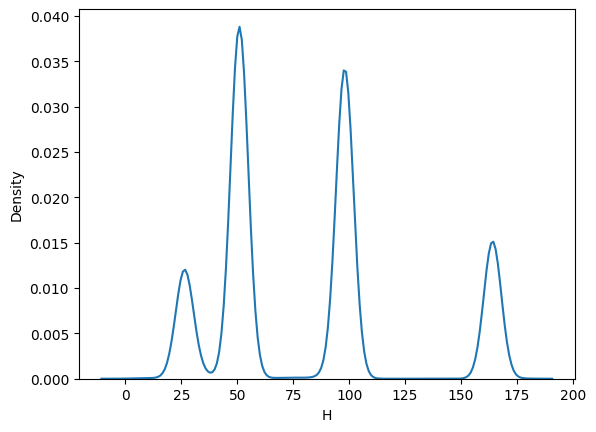

In [6]:
sns.kdeplot(ColorPixels.H)

In [7]:
Model = (
    MeanShift(bandwidth=15, n_jobs=4)
    .fit(ColorPixels.H.array.reshape(-1, 1))
)

ColorClusters = (
    ColorPixels
    .assign(cluster = Model.labels_ + 3) # Add 3 because black, white, and gray are the first 3 clusters
)

In [11]:
def name_clusters(cluster, H):
    if cluster == 0:
        return 'Black'
    elif cluster == 1:
        return 'White'
    elif cluster == 2:
        return 'Gray'
    else:
        H = H * 2
        if H < 15:
            return 'Red'
        elif 15 < H <= 45:
            return 'Orange'
        elif 45 < H <= 90:
            return 'Yellow'
        elif 90 < H <= 150:
            return 'Green'
        elif 150 < H <= 180:
            return 'Cyan'
        elif 180 < H <= 255:
            return 'Blue'
        elif 255 < H <= 280:
            return 'Violet'
        else:
            return 'Magenta'

# Combine gray clusters and color clusterts
Clusters = (
    pd.concat([ColorClusters,GrayClusters])
    .sort_index()
)

TotalPixels = len(Clusters)

# Aggregate, name and calculate summary statistics for each cluster
cluster_summary = (
    Clusters
    .groupby('cluster')
    .agg(
        Mode_H = ('H', lambda x: x.mode()[0]),
        Mode_S = ('S', lambda x: x.mode()[0]),
        Mode_V = ('V', lambda x: x.mode()[0]),
        Count = ('H', 'count'),
    )
    .reset_index()
    .sort_values('Count',ascending=False)
    .assign(
        Percentage = lambda x: x['Count'] / TotalPixels,
        Cumulative = lambda x: x['Percentage'].cumsum(),
        Rank = lambda x: x['Count'].rank(method='dense', ascending=False).astype(int),
        Name = lambda x: x.apply(lambda y: name_clusters(y['cluster'], y['Mode_H']), axis=1),
    )
    .set_index('Rank')
)

display(cluster_summary)

,cluster,Mode_H,Mode_S,Mode_V,Count,Percentage,Cumulative,Name
Rank,,,,,,,,
1,3,51,198,175,61638,0.251584,0.251584,Green
2,0,0,0,0,60067,0.245171,0.496755,Black
3,4,98,251,182,54485,0.222388,0.719143,Blue
4,5,164,218,242,23990,0.097918,0.817061,Magenta
5,6,26,250,255,19920,0.081306,0.898367,Yellow
6,1,0,0,255,14836,0.060555,0.958922,White
7,2,0,0,35,10064,0.041078,1.000000,Gray


## Remove Irrelevant Clusters

Use greedy methods to find color clusters that meet a minimum coverage threshold

In [16]:
mask = cluster_summary['Cumulative'] >= area_threshold
Final_Clusters = cluster_summary.loc[:mask.idxmax()]

display(Final_Clusters)

,cluster,Mode_H,Mode_S,Mode_V,Count,Percentage,Cumulative,Name
Rank,,,,,,,,
1,3,51,198,175,61638,0.251584,0.251584,Green
2,0,0,0,0,60067,0.245171,0.496755,Black
3,4,98,251,182,54485,0.222388,0.719143,Blue
4,5,164,218,242,23990,0.097918,0.817061,Magenta
5,6,26,250,255,19920,0.081306,0.898367,Yellow


In [17]:
Output = (
    Final_Clusters
    .assign(File = image_file)
    .reset_index(drop=True)
    .loc[:,['File','Name']]
    .drop_duplicates()
)

display(Output)

,File,Name
0,sevens.jpg,Green
1,sevens.jpg,Black
2,sevens.jpg,Blue
3,sevens.jpg,Magenta
4,sevens.jpg,Yellow
